<a href="https://colab.research.google.com/github/Amiya-Kalita/Machine-Learning/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Single-Scale Head Detection and Crowd Counting Project on the **ShanghaiTech** Dataset Using a **VGG16**-Based Deep Learning Model in PyTorch*

####  `Project ID`: P1
#### `Name` : `Amiya kalita`
#### `DataSet` : ShanghaiTech

## `Dataset Description: ShanghaiTech Crowd Counting Dataset`

The **ShanghaiTech Crowd Counting Dataset** is a widely used benchmark dataset for evaluating crowd counting and head detection algorithms in computer vision. It contains images of highly crowded scenes with large variations in crowd density, perspective, and background complexity. Dataset Download Link : https://www.kaggle.com/datasets/tthien/shanghaitech/code

The dataset is divided into **two main parts: Part A and Part B**, each designed to evaluate different crowd scenarios.


### 📁 Dataset Structure

```

ShanghaiTech/
│
├── part_A/
│   ├── train_data/
│   │   ├── images/
│   │   └── ground-truth/
│   └── test_data/
│       ├── images/
│       └── ground-truth/
│
└── part_B/
├── train_data/
│   ├── images/
│   └── ground-truth/
└── test_data/
├── images/
└── ground-truth/

````

###  `Part A: Dense Crowd Scenes`

- **Source**: Internet images
- **Characteristics**:
  - Extremely dense crowds
  - Large variations in scale and perspective
  - High head overlap and occlusion
- **Typical Use**:
  - Evaluating models under **very challenging crowd conditions**
  - Dense head detection and counting

**Statistics (Approximate)**:
- Training images: ~300
- Testing images: ~182
- Crowd count per image: up to **3000+ people**

### `Part B: Sparse Crowd Scenes`

- **Source**: Surveillance camera images
- **Characteristics**:
  - Relatively sparse crowds
  - More uniform head sizes
  - Lower background complexity
- **Typical Use**:
  - Evaluating performance in **real-world surveillance scenarios**
  - Easier detection and counting compared to Part A

**Statistics (Approximate)**:
- Training images: ~400
- Testing images: ~316
- Crowd count per image: usually **below 100**

### Ground Truth Annotation Format

- Ground truth annotations are stored in **MATLAB `.mat` files**
- Each file contains:
  - **Head center coordinates** in pixel space
  - Format:  
    ```
    [x, y]
    ```
    where:
    - `x` is the horizontal pixel location
    - `y` is the vertical pixel location

- Each point represents the **center of a human head** in the image.

These annotations can be used to:
- Generate **bounding boxes**
- Create **density maps**
- Perform **head detection and crowd counting**

### Step 1 — `Mount Drive and Check GPU`

In [1]:
# Import Google Colab utility to access Google Drive
from google.colab import drive

# Mount Google Drive to the Colab environment
# After mounting, files will be accessible at /content/drive/MyDrive/
drive.mount('/content/drive')

# Import PyTorch library for deep learning and GPU computation
import torch

# Check whether CUDA (GPU support) is available in the current runtime
print("CUDA available:", torch.cuda.is_available())

# If CUDA is available, print the name of the GPU device
if torch.cuda.is_available():
    # Index 0 refers to the first available GPU
    print("Device:", torch.cuda.get_device_name(0))

Mounted at /content/drive
CUDA available: True
Device: Tesla T4


### Step 2 - `Install and import libraries`

In [2]:
# Install PyTorch core libraries
!pip install -q torch torchvision torchaudio

# Install computer vision, scientific, and visualization libraries
!pip install -q opencv-python-headless scipy h5py matplotlib seaborn tqdm

# importing  Standard Python imports
import os            # <---- File and directory handling
import math          # < --- Mathematical functions
import random        # <--- Random number generation
import glob          # <--- File pattern matching

# Scientific computing imports
import numpy as np   # <--- Numerical operations
import cv2           # <--- OpenCV for image processing
import h5py          # <--- Reading .h5 files (density maps / annotations)

from tqdm import tqdm              # <--- Progress bars
from scipy.io import loadmat       # <--- Load MATLAB .mat files

# PyTorch core imports
import torch                         # <--- Core PyTorch
import torch.nn as nn                # <--- Neural network layers
import torch.optim as optim          # <-- Optimizers
from torch.utils.data import Dataset, DataLoader  # <--- Dataset utilities

# TorchVision imports
import torchvision                   # <--- Vision utilities
from torchvision import transforms   # <--- Image transformations

# Backbone CNN models
from torchvision.models import vgg16, resnet50

# Object detection framework
from torchvision.models.detection import FasterRCNN

# Anchor generator for RPN
from torchvision.models.detection.rpn import AnchorGenerator

# Vision-specific operations (IoU, NMS, etc.)
import torchvision.ops as ops

# Visualization imports
import matplotlib.pyplot as plt      # <-- Plotting
import seaborn as sns                # <--- Statistical visualization

### Step 3 - `Defining Dataset paths`

In [3]:
# Root path of the ShanghaiTech dataset in Google Drive
dataset_path = "/content/drive/MyDrive/ShanghaiTech"

# Path to ShanghaiTech Part A (high-density crowds)
part_A = os.path.join(dataset_path, "part_A")

# Path to ShanghaiTech Part B (low-density crowds)
part_B = os.path.join(dataset_path, "part_B")

# Part A training and testing directories
train_a_data = os.path.join(part_A, "train_data")
test_a_data  = os.path.join(part_A, "test_data")

# Part B training and testing directories
train_b_data = os.path.join(part_B, "train_data")
test_b_data  = os.path.join(part_B, "test_data")

# Print paths for verification
print("Part A train:", train_a_data)
print("Part A test :", test_a_data)
print("Part B train:", train_b_data)
print("Part B test :", test_b_data)

# Ensure all required directories exist before proceeding
for p in [train_a_data, test_a_data, train_b_data, test_b_data]:
    assert os.path.exists(p), f"Missing path: {p}"

Part A train: /content/drive/MyDrive/ShanghaiTech/part_A/train_data
Part A test : /content/drive/MyDrive/ShanghaiTech/part_A/test_data
Part B train: /content/drive/MyDrive/ShanghaiTech/part_B/train_data
Part B test : /content/drive/MyDrive/ShanghaiTech/part_B/test_data


### `Dataset Sanity Check ShanghaiTech Part_A`

TRAIN_IMAGES: /content/drive/MyDrive/ShanghaiTech/part_A/train_data/images
TRAIN_GT    : /content/drive/MyDrive/ShanghaiTech/part_A/train_data/ground-truth
Image path: /content/drive/MyDrive/ShanghaiTech/part_A/train_data/images/IMG_1.jpg
GT path   : /content/drive/MyDrive/ShanghaiTech/part_A/train_data/ground-truth/GT_IMG_1.mat
Image shape (H, W, C): (768, 1024, 3)
Number of heads: 1546
First 5 head centers:
 [[ 29.6225116  472.92022152]
 [ 54.35533603 454.96602305]
 [ 51.79045053 460.46220626]
 [ 51.79045053 465.77518336]
 [ 50.87442    473.65304595]]


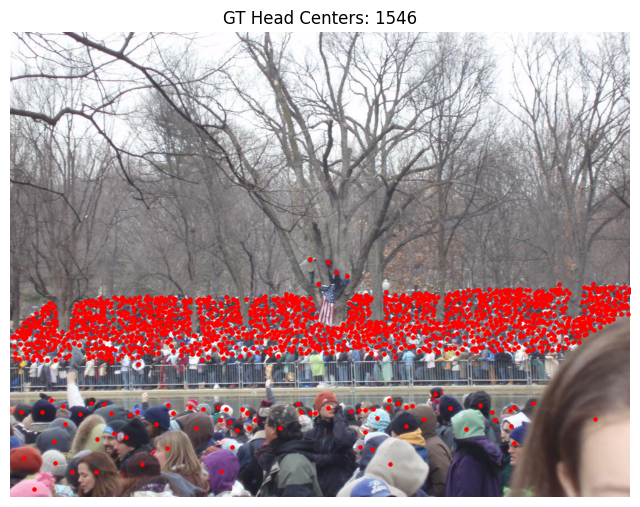

In [23]:
import os
import scipy.io as sio
import cv2
import matplotlib.pyplot as plt

# Define Part A paths clearly

TRAIN_IMAGES = os.path.join(train_a_data, "images")
TRAIN_GT     = os.path.join(train_a_data, "ground-truth")

print("TRAIN_IMAGES:", TRAIN_IMAGES)
print("TRAIN_GT    :", TRAIN_GT)

# Sanity check
assert os.path.exists(TRAIN_IMAGES), "TRAIN_IMAGES folder not found"
assert os.path.exists(TRAIN_GT), "TRAIN_GT folder not found"

# 2. Pick one training image + its GT file
# list all jpg images in the train images folder
img_list = sorted([f for f in os.listdir(TRAIN_IMAGES) if f.lower().endswith(".jpg")])
assert len(img_list) > 0, "No .jpg files found in TRAIN_IMAGES"

img_name = img_list[0]                        # choose the first image
img_path = os.path.join(TRAIN_IMAGES, img_name)

# ground-truth file: GT_IMG_XXX.mat (same id as image)
gt_name = "GT_" + img_name.replace(".jpg", ".mat")
gt_path = os.path.join(TRAIN_GT, gt_name)

print("Image path:", img_path)
print("GT path   :", gt_path)
assert os.path.exists(gt_path), "Ground-truth .mat file not found for this image"

# Load and inspect the image
image = cv2.imread(img_path)                  # BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Image shape (H, W, C):", image.shape)

#  Load ground-truth annotation (.mat)
mat = sio.loadmat(gt_path)

# ShanghaiTech Part A format:
# mat["image_info"][0][0][0][0][0] -> (N, 2) array of [x, y] head centers
points = mat["image_info"][0][0][0][0][0]

print("Number of heads:", points.shape[0])
print("First 5 head centers:\n", points[:5])

#  Visualize head centers on the image
plt.figure(figsize=(8, 8))
plt.imshow(image)

for (x, y) in points:
    plt.scatter(x, y, c='red', s=5)          # red dot at each head center

plt.title(f"GT Head Centers: {points.shape[0]}")
plt.axis("off")
plt.show()

### `Dataset Sanity Check ShanghaiTech Part_B`

TRAIN_IMAGES_B: /content/drive/MyDrive/ShanghaiTech/part_B/train_data/images
TRAIN_GT_B    : /content/drive/MyDrive/ShanghaiTech/part_B/train_data/ground-truth
Image path (B): /content/drive/MyDrive/ShanghaiTech/part_B/train_data/images/IMG_1.jpg
GT path (B)   : /content/drive/MyDrive/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat
Image_B shape (H, W, C): (768, 1024, 3)
Number of heads (B): 233
First 5 head centers (B):
 [[ 32.67954877 753.52165403]
 [184.60695349 690.79933098]
 [344.89733461 577.8991495 ]
 [328.1713818  536.08426746]
 [329.5652112  473.36194441]]


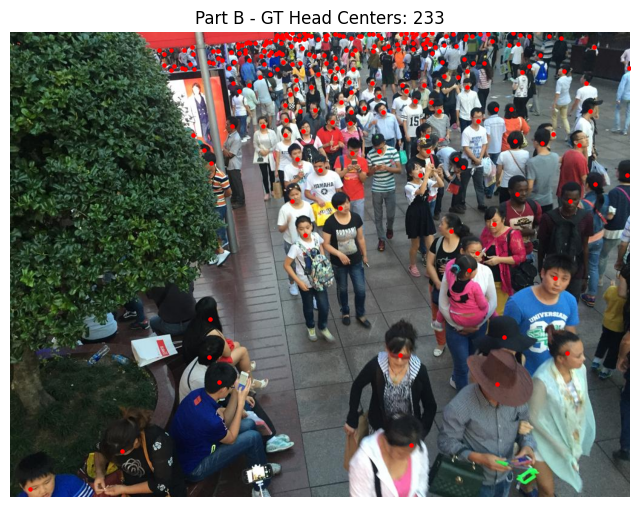

In [24]:
# Define Part B paths
TRAIN_IMAGES_B = os.path.join(train_b_data, "images")
TRAIN_GT_B     = os.path.join(train_b_data, "ground-truth")

print("TRAIN_IMAGES_B:", TRAIN_IMAGES_B)
print("TRAIN_GT_B    :", TRAIN_GT_B)

assert os.path.exists(TRAIN_IMAGES_B), "TRAIN_IMAGES_B folder not found"
assert os.path.exists(TRAIN_GT_B), "TRAIN_GT_B folder not found"

# Pick one training image + its GT file
img_list_b = sorted([f for f in os.listdir(TRAIN_IMAGES_B) if f.lower().endswith(".jpg")])
assert len(img_list_b) > 0, "No .jpg files found in TRAIN_IMAGES_B"

img_name_b = img_list_b[0]                           # first image
img_path_b = os.path.join(TRAIN_IMAGES_B, img_name_b)

# GT file: GT_IMG_XXX.mat (same id as image)
gt_name_b = "GT_" + img_name_b.replace(".jpg", ".mat")
gt_path_b = os.path.join(TRAIN_GT_B, gt_name_b)

print("Image path (B):", img_path_b)
print("GT path (B)   :", gt_path_b)
assert os.path.exists(gt_path_b), "Ground-truth .mat file not found for this Part B image"

# 3. Load and inspect the image
image_b = cv2.imread(img_path_b)                     # BGR
image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB)   # RGB

print("Image_B shape (H, W, C):", image_b.shape)

#  Load ground-truth annotation (.mat)
mat_b = sio.loadmat(gt_path_b)

# ShanghaiTech Part B usually uses the same image_info structure
# image_info[0][0][0][0][0] -> (N, 2) [x, y]
points_b = mat_b["image_info"][0][0][0][0][0]

print("Number of heads (B):", points_b.shape[0])
print("First 5 head centers (B):\n", points_b[:5])

#  Visualize head centers on the image
plt.figure(figsize=(8, 8))
plt.imshow(image_b)

for (x, y) in points_b:
    plt.scatter(x, y, c='red', s=5)

plt.title(f"Part B - GT Head Centers: {points_b.shape[0]}")
plt.axis("off")
plt.show()

### Step 4 - `Read .mat annotations and convert to boxes`

In [4]:
from scipy.io import loadmat  # <--- Imports loadmat, which reads MATLAB .mat files into Python.
import numpy as np


def load_head_points(mat_path):
    """
    Load head center points from a ShanghaiTech .mat ground-truth file.
    Handles multiple annotation formats robustly.
    """

    # Load the .mat file
    data = loadmat(mat_path)

    # Standard ShanghaiTech annotation key
    if 'image_info' in data:
        info = data['image_info']

        try:
            # Most common nested format -> (N, 2) array of (x, y)
            pts = info[0][0][0][0][0]
        except Exception:
            # Fallback for alternative struct layouts
            pts_list = []
            for item in info[0, 0][0]:
                loc = item['location'][0, 0]
                pts_list.append(loc)
            pts = np.concatenate(pts_list, axis=0)

    else:
        # Fallback for non-standard annotation keys
        for key in data.keys():
            if 'annPoints' in key or 'loc' in key:
                pts = data[key]
                break

    # Ensure float32 and correct shape (N, 2)
    pts = np.asarray(pts, dtype=np.float32)
    if pts.ndim == 1:
        pts = pts.reshape(-1, 2)

    return pts


def points_to_boxes(points, box_size=20):
    """
    Convert head center points into square bounding boxes (x1, y1, x2, y2).
    """

    boxes = []

    for x, y in points:
        # Create a square box centered at (x, y)
        x1 = x - box_size / 2
        y1 = y - box_size / 2
        x2 = x + box_size / 2
        y2 = y + box_size / 2
        boxes.append([x1, y1, x2, y2])

    return np.array(boxes, dtype=np.float32)

##

### Step 5 - `Defining PyTorch dataset class`

In [5]:
class ShanghaiHeadDetect(Dataset):
    def __init__(
        self,
        root_dir,
        img_folder="images",
        gt_folder="ground-truth",
        transform=None,
        fixed_size=(512, 512),
        max_images=None,
        box_size=20,
    ):
        # Image and ground-truth directories
        self.img_dir = os.path.join(root_dir, img_folder)
        self.gt_dir = os.path.join(root_dir, gt_folder)

        # Collect all image paths
        self.img_paths = sorted(glob.glob(os.path.join(self.img_dir, "*.jpg")))

        # Optionally limit dataset size
        if max_images:
            self.img_paths = self.img_paths[:max_images]

        # Store configuration
        self.transform = transform
        self.fixed_size = fixed_size
        self.box_size = box_size

    def __len__(self):
        # Total number of images
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image path and base filename
        img_path = self.img_paths[idx]
        filename = os.path.splitext(os.path.basename(img_path))[0]

        # Find matching ground-truth .mat file
        possible_mat = glob.glob(os.path.join(self.gt_dir, f"*{filename}*.mat"))
        if len(possible_mat) == 0:
            raise FileNotFoundError(f"No GT for {filename}")
        gt_path = possible_mat[0]

        # Read image and convert BGR to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h0, w0 = img.shape[:2]

        # Load head center points and convert to bounding boxes
        points = load_head_points(gt_path)
        boxes = points_to_boxes(points, box_size=self.box_size)

        # Resize image and scale bounding boxes accordingly
        new_w, new_h = self.fixed_size
        img_resized = cv2.resize(img, (new_w, new_h))
        scale_x = new_w / w0
        scale_y = new_h / h0
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

        # Convert image to tensor and apply optional transforms
        img_tensor = transforms.ToTensor()(img_resized)
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # Build Faster R-CNN compatible target dictionary
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.ones((boxes.shape[0],), dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = (
            (target["boxes"][:, 3] - target["boxes"][:, 1]) *
            (target["boxes"][:, 2] - target["boxes"][:, 0])
        )
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        return img_tensor, target

##

### Step 6 - `Collate and transforms`

In [6]:
def collate_fn(batch):
    """
    Custom collate function for object detection tasks.
    Each sample in the batch is a (image, target) tuple.
    This function groups images and targets separately without stacking,
    which is required by torchvision detection models.
    """
    return tuple(zip(*batch))

# Training-time transforms
train_transform = transforms.Compose([
    # Ensure image tensor is float32 (required by PyTorch models)
    transforms.ConvertImageDtype(torch.float32),
])

# Evaluation / test-time transforms
test_transform = transforms.Compose([
    # Keep preprocessing consistent with training
    transforms.ConvertImageDtype(torch.float32),
])

### Step 7 - `CBAM modules`

In [7]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super().__init__()

        # Shared MLP used for channel-wise attention weighting
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // ratio, in_channels, bias=False),
        )

        # Global average pooling and max pooling over spatial dimensions
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Sigmoid to normalize channel attention weights
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Extract batch size and channel count
        b, c, _, _ = x.size()

        # Pool spatial information into channel descriptors
        avg = self.avg_pool(x).view(b, c)
        mx  = self.max_pool(x).view(b, c)

        # Apply shared MLP and combine average + max responses
        out = self.mlp(avg) + self.mlp(mx)

        # Generate channel attention map
        out = self.sigmoid(out).view(b, c, 1, 1)

        # Reweight input feature maps channel-wise
        return x * out


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()

        # Padding to preserve spatial resolution
        padding = (kernel_size - 1) // 2

        # Convolution applied on concatenated average and max maps
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

        # Sigmoid to normalize spatial attention map
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute channel-wise average and max projections
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)

        # Concatenate along channel dimension
        x_cat = torch.cat([avg, mx], dim=1)

        # Generate spatial attention map
        attn = self.sigmoid(self.conv(x_cat))

        # Reweight input feature maps spatially
        return x * attn


class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super().__init__()

        # Channel attention module
        self.ca = ChannelAttention(in_channels, ratio)

        # Spatial attention module
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        # Apply channel attention followed by spatial attention
        x = self.ca(x)
        x = self.sa(x)
        return x

### Step 8 - `Cell 8 – Backbone builder (VGG16/ResNet50 + CBAM)`

In [8]:
def build_backbone(backbone_name="vgg16", use_cbam=True):
    # Select backbone architecture
    if backbone_name.lower() == "vgg16":
        # Load pretrained VGG16 model
        base = vgg16(weights="IMAGENET1K_V1")

        # Use only convolutional feature extractor
        features = list(base.features.children())
        backbone = nn.Sequential(*features)

        # Output channel depth of VGG16 features
        out_channels = 512

    elif backbone_name.lower() == "resnet50":
        # Load pretrained ResNet50 model
        base = resnet50(weights="IMAGENET1K_V1")

        # Remove global pooling and classification layers
        modules = list(base.children())[:-2]
        backbone = nn.Sequential(*modules)

        # Output channel depth of ResNet50 features
        out_channels = 2048

    else:
        # Reject unsupported backbone choices
        raise ValueError("backbone_name must be 'vgg16' or 'resnet50'")

    # Optionally append CBAM attention module
    if use_cbam:
        backbone.add_module("cbam", CBAM(out_channels))

    # Required attribute for torchvision detection models
    backbone.out_channels = out_channels

    return backbone

### Step 9 – `Build Faster R‑CNN detector (HeadBox‑Simple)`

In [9]:
def get_headbox_model(num_classes=2, backbone_name="vgg16", use_cbam=True):
    # Build feature extraction backbone (VGG16 or ResNet50)
    backbone = build_backbone(backbone_name, use_cbam=use_cbam)

    # Define anchor sizes and aspect ratios for the RPN
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),),
    )

    # Configure RoI Align for pooling proposal features
    roi_pooler = ops.MultiScaleRoIAlign(
        featmap_names=['0'],   # <--- Feature map keys used from the backbone output (single-scale backbone → '0')
        output_size=7,   # <---  Spatial size (H, W) of the pooled RoI feature (7×7 is standard for Faster R-CNN)
        sampling_ratio=2,  # <---  Number of sampling points per bin (2 improves alignment accuracy)
    )

    # Construct Faster R-CNN detection model
    model = FasterRCNN(
        backbone=backbone,    # <-----  Backbone network providing feature maps
        num_classes=num_classes,   # <----- Number of output classes (including background)
        rpn_anchor_generator=anchor_generator,  # < ----  Anchor generator defining RPN anchor sizes and aspect ratios
        box_roi_pool=roi_pooler,   # < ----  RoI pooling mechanism used for proposal feature extraction
    )

    return model

### Step 10 – `Dataloaders for Part A and B`

In [10]:
def get_loaders(
    part="A",                 # <--- Dataset split selector: "A" = Part A (high density), "B" = Part B (low density)
    batch_size=2,             # <---- Number of images per training batch (small value to fit GPU memory)
    max_train=None,           # <--- Optional limit on number of training images (useful for debugging)
    max_test=None,            # < --- Optional limit on number of test images (useful for quick evaluation)
    fixed_size=(512, 512),    # <---- Fixed image resolution (width, height) used for resizing images
):

    # Select dataset paths based on chosen part (A or B)
    if part.upper() == "A":
        train_root = train_a_data   # <--- Training directory for ShanghaiTech Part A
        test_root  = test_a_data    # <--- Testing directory for ShanghaiTech Part A
    else:
        train_root = train_b_data   # <--- Training directory for ShanghaiTech Part B
        test_root  = test_b_data    # <--- Testing directory for ShanghaiTech Part B

    # Create training dataset
    train_dataset = ShanghaiHeadDetect(
        train_root,
        transform=train_transform,       # <--- Uses training transforms
        fixed_size=fixed_size,           # <--- Applies fixed image resizing
        max_images=max_train,     #  <---- Optionally limits dataset size
    )

    # Create testing dataset
    test_dataset = ShanghaiHeadDetect(
        test_root,
        transform=test_transform,    # <--- Uses test transforms only (no augmentation)
        fixed_size=fixed_size,       # <--- Same fixed image resizing as training
        max_images=max_test,   # < --- Optionally limits dataset size
    )

    # Training DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,                             # <--- shuffle=True for stochastic training
        num_workers=0,                       # <---- num_workers=0 recommended for Colab stability
        collate_fn=collate_fn,                # <---- collate_fn required for detection targets
    )

    # Testing DataLoader


    # --------------------------------------------------
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,        # <---- batch_size=1 simplifies evaluation and visualization
        shuffle=False,       # <---- shuffle=False preserves dataset order
        num_workers=0,     # <---- num_workers=0 recommended for Colab stability
        collate_fn=collate_fn,      # <---- collate_fn required for detection targets
    )

    # Return datasets and dataloaders
    return train_dataset, test_dataset, train_loader, test_loader

# Build datasets and dataloaders for ShanghaiTech Part A
train_dataset_A, test_dataset_A, train_loader_A, test_loader_A = get_loaders(
    part="A",          # Use Part A of the dataset
    batch_size=2,      # Two images per training batch
)

# Print dataset sizes for sanity verification
print("Part A:", len(train_dataset_A), "train,", len(test_dataset_A), "test")

Part A: 300 train, 182 test


## Step 11 – `Training utilities (fixed autocast + evaluation)`

In [11]:
# Select computation device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # <--- Automatically choose CUDA or CPU
print("Using device:", device)                                          # <--- Print selected device for verification


def train_one_epoch(
    model,
    optimizer,
    data_loader,
    device,
    epoch,
    print_freq=20,             # <---- Frequency (in steps) to print training loss
):
    model.train()              # <--- Set model to training mode (enables dropout, BN updates)
    total_loss = 0.0           # <--- Accumulate total loss over the epoch

    # Iterate over training batches
    for i, (images, targets) in enumerate(data_loader):

        # Move images to the selected device
        images = [img.to(device) for img in images]   # <--- List of image tensors

        # Move target dictionaries to the selected device
        targets = [
            {k: v.to(device) for k, v in t.items()}   # <--- boxes, labels, etc.
            for t in targets
        ]

        # Enable mixed-precision training on CUDA for speed and memory efficiency
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            loss_dict = model(images, targets)        # <--- Forward pass returns loss components
            losses = sum(loss for loss in loss_dict.values())  # <--- Total loss = sum of all components

        optimizer.zero_grad()     # <--- Clear gradients from previous step
        losses.backward()         # <--- Backpropagate total loss
        optimizer.step()          # <--- Update model parameters

        total_loss += losses.item()   # <--- Accumulate scalar loss value

        # Print training progress periodically
        if (i + 1) % print_freq == 0:
            print(
                f"Epoch {epoch} | Step {i+1}/{len(data_loader)} | "
                f"Loss: {losses.item():.4f}"
            )

    # Return average loss over the entire epoch
    return total_loss / len(data_loader)


@torch.no_grad()   # <--- Disable gradient computation for evaluation
def evaluate_count_mae(
    model,
    data_loader,
    device,
    score_thresh=0.5,      # <--- Confidence threshold for counting detections
):
    model.eval()           # <--- Set model to evaluation mode (disable dropout, BN updates)
    mae = 0.0              # <--- Mean Absolute Error accumulator
    mse = 0.0              # <--- Mean Squared Error accumulator
    n = 0                  # <--- Number of evaluated images

    # Iterate over test dataset
    for images, targets in data_loader:

        # Move images to device
        images = [img.to(device) for img in images]

        # Move targets to device
        targets = [
            {k: v.to(device) for k, v in t.items()}
            for t in targets
        ]

        # Forward pass (inference mode)
        outputs = model(images)   # <--- Returns predicted boxes, scores, labels

        # Compare predicted count vs ground-truth count
        for out, tgt in zip(outputs, targets):
            scores = out["scores"].detach().cpu().numpy()  # <--- Detection confidence scores
            pred_count = int((scores > score_thresh).sum())  # <--- Count predictions above threshold
            true_count = int(tgt["boxes"].shape[0])          # <--- Ground-truth head count

            diff = pred_count - true_count   # <--- Counting error for this image
            mae += abs(diff)                 # <--- Accumulate absolute error
            mse += diff ** 2                 # <--- Accumulate squared error
            n += 1                           # <--- Increment image counter

    # Handle edge case: empty dataset
    if n == 0:
        return 0.0, 0.0

    # Final MAE and RMSE computation
    mae /= n                                 # <--- Mean Absolute Error
    rmse = math.sqrt(mse / n)                # <--- Root Mean Squared Error

    return mae, rmse

Using device: cuda


### Step 12 – `Train model on Part A`

In [12]:
# Training configuration
num_epochs = 30                       # <--- Total number of training epochs
backbone_name = "vgg16"               # <--- Backbone architecture ("vgg16" or "resnet50")
use_cbam = True                       # <--- Enable CBAM attention module

# <------Model initialization
# Build Faster R-CNN head detection model
model_A = get_headbox_model(
    num_classes=2,                    # <--- 1 class (head) + background
    backbone_name=backbone_name,      # <--- Selected CNN backbone
    use_cbam=use_cbam,                # <--- Toggle CBAM attention
)

model_A.to(device)                   # <--- Move model to GPU or CPU

# <----- Optimizer setup
# Select only trainable parameters
params = [p for p in model_A.parameters() if p.requires_grad]  # <--- Exclude frozen params

# AdamW optimizer (stable for detection models)
optimizer = optim.AdamW(
    params,
    lr=1e-4,                          # <--- Learning rate
)

# Training state tracking
best_mae = float("inf")               # <--- Track best validation MAE
history_A = {
    "train_loss": [],                 # <--- Store average training loss per epoch
    "val_mae": [],                    # <--- Store validation MAE per epoch
    "val_rmse": [],                   # <--- Store validation RMSE per epoch
}

# Training + Evaluation loop
for epoch in range(1, num_epochs + 1):

    # Train model for one epoch
    loss_epoch = train_one_epoch(
        model_A,
        optimizer,
        train_loader_A,
        device,
        epoch,
    )

    # Evaluate counting performance on validation set
    mae, rmse = evaluate_count_mae(
        model_A,
        test_loader_A,
        device,
        score_thresh=0.5,              # <--- Confidence threshold for counting heads
    )

    # Log metrics
    history_A["train_loss"].append(loss_epoch)
    history_A["val_mae"].append(mae)
    history_A["val_rmse"].append(rmse)

    # Print epoch summary
    print(
        f"Epoch {epoch} | "
        f"Loss={loss_epoch:.4f} | "
        f"Val MAE={mae:.2f} | "
        f"Val RMSE={rmse:.2f}"
    )

    # Save model if validation MAE improves
    if mae < best_mae:
        best_mae = mae                                    # <--- Update best MAE
        torch.save(
            model_A.state_dict(),
            "/content/drive/MyDrive/headbox_partA_best.pth",  # <--- Save best model checkpoint
        )
        print("Saved best model for Part A (MAE improved).")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 99.2MB/s]


Epoch 1 | Step 20/150 | Loss: 1.4692
Epoch 1 | Step 40/150 | Loss: 1.3380
Epoch 1 | Step 60/150 | Loss: 1.5952
Epoch 1 | Step 80/150 | Loss: 1.1690
Epoch 1 | Step 100/150 | Loss: 1.2627
Epoch 1 | Step 120/150 | Loss: 1.4065
Epoch 1 | Step 140/150 | Loss: 1.2967
Epoch 1 | Loss=1.6847 | Val MAE=431.99 | Val RMSE=569.38
Saved best model for Part A (MAE improved).
Epoch 2 | Step 20/150 | Loss: 1.5469
Epoch 2 | Step 40/150 | Loss: 14.2659
Epoch 2 | Step 60/150 | Loss: 1.1871
Epoch 2 | Step 80/150 | Loss: 1.2825
Epoch 2 | Step 100/150 | Loss: 1.1775
Epoch 2 | Step 120/150 | Loss: 1.4046
Epoch 2 | Step 140/150 | Loss: 1.1585
Epoch 2 | Loss=1.5937 | Val MAE=431.99 | Val RMSE=569.38
Epoch 3 | Step 20/150 | Loss: 1.2253
Epoch 3 | Step 40/150 | Loss: 1.2136
Epoch 3 | Step 60/150 | Loss: 1.0837
Epoch 3 | Step 80/150 | Loss: 1.2311
Epoch 3 | Step 100/150 | Loss: 1.4459
Epoch 3 | Step 120/150 | Loss: 1.2086
Epoch 3 | Step 140/150 | Loss: 1.3531
Epoch 3 | Loss=1.4980 | Val MAE=421.10 | Val RMSE=559.3

### Step 13 – `Plot curves for Part A`

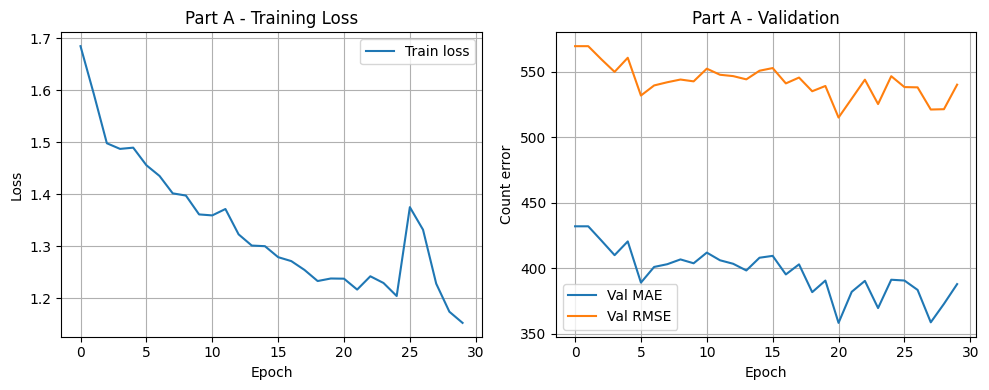

In [13]:
# Create a figure for training and validation plots
plt.figure(figsize=(10, 4))                    # <--- Set overall figure size (width, height)

# Plot 1: Training Loss
plt.subplot(1, 2, 1)                           # <--- 1 row, 2 columns, first subplot
plt.plot(history_A["train_loss"], label="Train loss")  # <--- Training loss per epoch
plt.xlabel("Epoch")                            # <--- X-axis: training epochs
plt.ylabel("Loss")                             # <--- Y-axis: loss value
plt.title("Part A - Training Loss")            # <--- Plot title
plt.grid(True)                                 # <--- Enable grid for readability
plt.legend()                                   # <--- Show legend

# Plot 2: Validation Metrics
plt.subplot(1, 2, 2)                           # <--- 1 row, 2 columns, second subplot
plt.plot(history_A["val_mae"], label="Val MAE")     # <--- Validation Mean Absolute Error
plt.plot(history_A["val_rmse"], label="Val RMSE")   # <--- Validation Root Mean Squared Error
plt.xlabel("Epoch")                            # <--- X-axis: training epochs
plt.ylabel("Count error")                      # <--- Y-axis: counting error
plt.title("Part A - Validation")               # <--- Plot title
plt.grid(True)                                 # <--- Enable grid for readability
plt.legend()                                   # <--- Show legend

# Adjust layout to prevent overlapping labels
plt.tight_layout()                             # <--- Automatically adjust spacing

# Display the plots
plt.show()                                     # <--- Render plots on screen

### Step 14 – `Loaders and training for Part B`

In [14]:
# Build datasets and dataloaders for ShanghaiTech Part B
train_dataset_B, test_dataset_B, train_loader_B, test_loader_B = get_loaders(
    "B",                      # <--- Use Part B of the dataset (low-density scenes)
    batch_size=4,             # <---- Larger batch size possible due to lower crowd density
)

# Print dataset sizes for sanity checking
print(
    "Part B:",
    len(train_dataset_B),     # <--- Number of training images
    "train,",
    len(test_dataset_B),      # <--- Number of testing images
    "test",
)

# <----- Model initialization for Part B
# Build Faster R-CNN head detection model for Part B
model_B = get_headbox_model(
    num_classes=2,            # <--- 1 class (head) + background
    backbone_name=backbone_name,  # <--- Same backbone as Part A for consistency
    use_cbam=use_cbam,        # <--- Enable CBAM attention module
)

model_B.to(device)           # <--- Move model to GPU or CPU

# <---- Optimizer setup for Part B
# Select only trainable parameters
params_B = [
    p for p in model_B.parameters()
    if p.requires_grad        # <--- Exclude frozen parameters
]

# AdamW optimizer for stable detection training
optimizer_B = optim.AdamW(
    params_B,
    lr=1e-4,                  # <--- Learning rate
)

# Training state tracking for Part B
num_epochs_B = 20             # <--- Total number of training epochs for Part B
best_mae_B = float("inf")     # <--- Track best validation MAE
history_B = {
    "train_loss": [],         # <--- Store training loss per epoch
    "val_mae": [],            # <--- Store validation MAE per epoch
    "val_rmse": [],           # <--- Store validation RMSE per epoch
}

# Training + Evaluation loop for Part B
for epoch in range(1, num_epochs_B + 1):

    # Train model for one epoch
    loss_epoch = train_one_epoch(
        model_B,
        optimizer_B,
        train_loader_B,
        device,
        epoch,
    )

    # Evaluate counting performance on Part B test set
    mae, rmse = evaluate_count_mae(
        model_B,
        test_loader_B,
        device,
        score_thresh=0.5,      # <--- Confidence threshold for counting heads
    )

    # Log metrics
    history_B["train_loss"].append(loss_epoch)
    history_B["val_mae"].append(mae)
    history_B["val_rmse"].append(rmse)

    # Print epoch summary
    print(
        f"[Part B] Epoch {epoch} | "
        f"Loss={loss_epoch:.4f} | "
        f"Val MAE={mae:.2f} | "
        f"Val RMSE={rmse:.2f}"
    )

    # Save model if validation MAE improves
    if mae < best_mae_B:
        best_mae_B = mae                                    # <--- Update best MAE
        torch.save(
            model_B.state_dict(),
            "/content/drive/MyDrive/headbox_partB_best.pth",  # <--- Save best Part B model
        )
        print("Saved best model for Part B (MAE improved).")

Part B: 400 train, 316 test
Epoch 1 | Step 20/100 | Loss: 1.4128
Epoch 1 | Step 40/100 | Loss: 0.7556
Epoch 1 | Step 60/100 | Loss: 1.0401
Epoch 1 | Step 80/100 | Loss: 0.9089
Epoch 1 | Step 100/100 | Loss: 1.0554
[Part B] Epoch 1 | Loss=1.1203 | Val MAE=67.24 | Val RMSE=97.90
Saved best model for Part B (MAE improved).
Epoch 2 | Step 20/100 | Loss: 0.6745
Epoch 2 | Step 40/100 | Loss: 0.7878
Epoch 2 | Step 60/100 | Loss: 0.8868
Epoch 2 | Step 80/100 | Loss: 0.9502
Epoch 2 | Step 100/100 | Loss: 0.9900
[Part B] Epoch 2 | Loss=0.9179 | Val MAE=80.00 | Val RMSE=107.67
Epoch 3 | Step 20/100 | Loss: 0.9922
Epoch 3 | Step 40/100 | Loss: 1.0895
Epoch 3 | Step 60/100 | Loss: 0.9714
Epoch 3 | Step 80/100 | Loss: 1.2330
Epoch 3 | Step 100/100 | Loss: 0.8564
[Part B] Epoch 3 | Loss=0.9022 | Val MAE=79.57 | Val RMSE=108.40
Epoch 4 | Step 20/100 | Loss: 0.8108
Epoch 4 | Step 40/100 | Loss: 0.9401
Epoch 4 | Step 60/100 | Loss: 0.7987
Epoch 4 | Step 80/100 | Loss: 0.8729
Epoch 4 | Step 100/100 | Los

### Step 15 – `Curves for Part B`

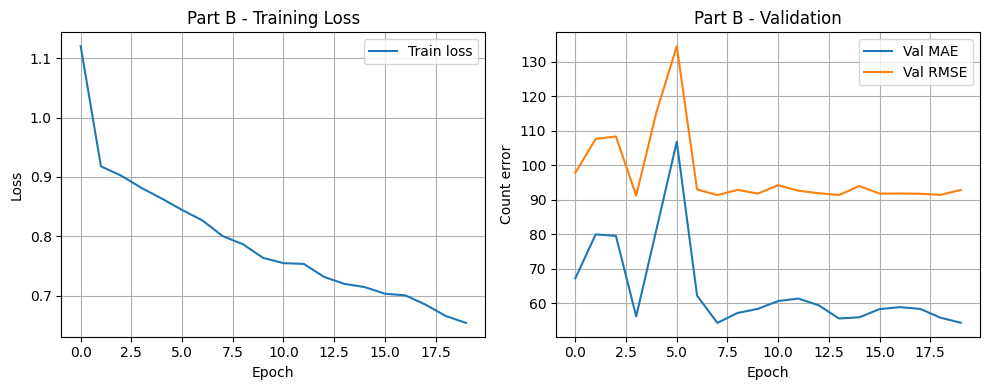

In [15]:
# Create a figure for Part B training and validation plots
plt.figure(figsize=(10, 4))                    # <--- Set overall figure size (width, height)

# Plot 1: Training Loss (Part B)
plt.subplot(1, 2, 1)                           # <--- 1 row, 2 columns, first subplot
plt.plot(history_B["train_loss"], label="Train loss")  # <--- Training loss per epoch
plt.xlabel("Epoch")                            # <--- X-axis: training epochs
plt.ylabel("Loss")                             # <--- Y-axis: loss value
plt.title("Part B - Training Loss")            # <--- Plot title
plt.grid(True)                                 # <--- Enable grid for readability
plt.legend()                                   # <--- Show legend

# Plot 2: Validation Metrics (Part B)
plt.subplot(1, 2, 2)                           # <--- 1 row, 2 columns, second subplot
plt.plot(history_B["val_mae"], label="Val MAE")     # <--- Validation Mean Absolute Error
plt.plot(history_B["val_rmse"], label="Val RMSE")   # <--- Validation Root Mean Squared Error
plt.xlabel("Epoch")                            # <--- X-axis: training epochs
plt.ylabel("Count error")                      # <--- Y-axis: counting error
plt.title("Part B - Validation")               # <--- Plot title
plt.grid(True)                                 # <--- Enable grid for readability
plt.legend()                                   # <--- Show legend

# Adjust layout to avoid overlapping labels and titles
plt.tight_layout()                             # <--- Automatically adjust subplot spacing

# Display the plots
plt.show()                                     # <--- Render plots on screen

### Step 16 – `Visualization function (side‑by‑side)`

In [16]:
@torch.no_grad()   # <--- Disable gradient computation for inference / visualization
def visualize_predictions(
    model,
    dataset,
    device,
    idx_list=None,          # <--- Specific image indices to visualize (random if None)
    score_thresh=0.5,       # <--- Confidence threshold for displaying predicted boxes
    max_images=5,           # <--- Maximum number of images to visualize
):
    model.eval()            # <--- Set model to evaluation mode

    # Select random image indices if none are provided
    if idx_list is None:
        idx_list = random.sample(
            range(len(dataset)),
            min(max_images, len(dataset)),
        )

    # Iterate over selected images
    for idx in idx_list:

        # Load image tensor and ground-truth target
        img_tensor, target = dataset[idx]

        # Move image to device
        img = img_tensor.to(device)

        # Run model inference (expects list of images)
        output = model([img])[0]    # <--- Single-image prediction output

        # Convert image tensor to NumPy format for visualization
        img_np = img.cpu().permute(1, 2, 0).numpy()   # <--- (C,H,W) → (H,W,C)
        img_np = np.clip(
            img_np * 255, 0, 255
        ).astype(np.uint8)           # <--- Convert to uint8 image

        # Extract predicted bounding boxes and confidence scores
        boxes = output["boxes"].detach().cpu().numpy()
        scores = output["scores"].detach().cpu().numpy()

        # Keep predictions above confidence threshold
        keep = scores > score_thresh
        boxes = boxes[keep]

        # Extract ground-truth bounding boxes
        true_boxes = target["boxes"].numpy()

        # Draw ground-truth boxes (blue)
        img_gt = img_np.copy()
        for (x1, y1, x2, y2) in true_boxes:
            cv2.rectangle(
                img_gt,
                (int(x1), int(y1)),
                (int(x2), int(y2)),
                (255, 0, 0),          # <--- Blue color for GT boxes
                2,
            )

        # Draw predicted boxes (green)
        img_pred = img_np.copy()
        for (x1, y1, x2, y2) in boxes:
            cv2.rectangle(
                img_pred,
                (int(x1), int(y1)),
                (int(x2), int(y2)),
                (0, 255, 0),          # <--- Green color for predicted boxes
                2,
            )

        # Count ground-truth and predicted heads
        true_count = len(true_boxes)    # <--- Actual head count
        pred_count = len(boxes)         # <--- Predicted head count

        # Display ground-truth vs prediction side by side
        plt.figure(figsize=(10, 5))     # <--- Create figure for comparison

        plt.subplot(1, 2, 1)
        plt.imshow(img_gt)
        plt.title(f"GT (count={true_count})")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_pred)
        plt.title(f"Pred (count={pred_count})")
        plt.axis("off")

        plt.tight_layout()              # <--- Adjust layout spacing
        plt.show()                      # <--- Render visualization

### Step 17 – `Visualize Part A predictions`

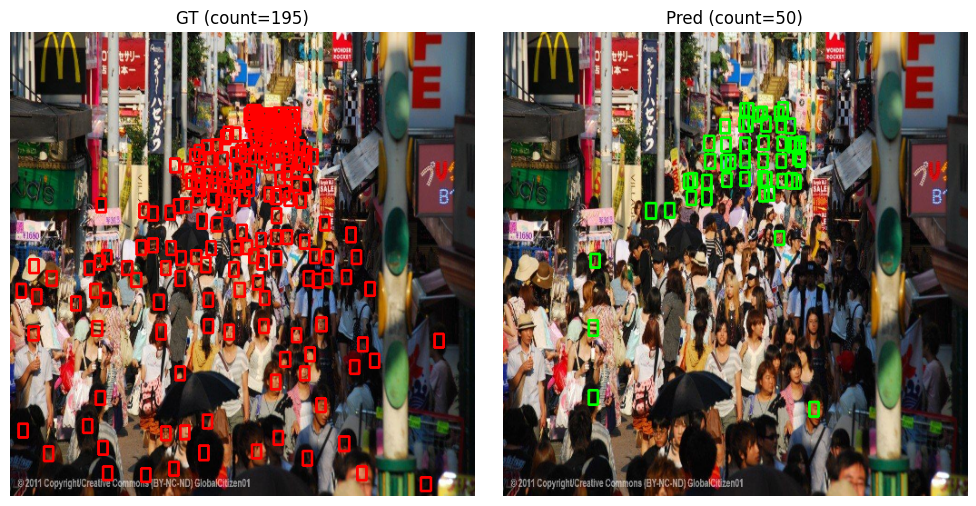

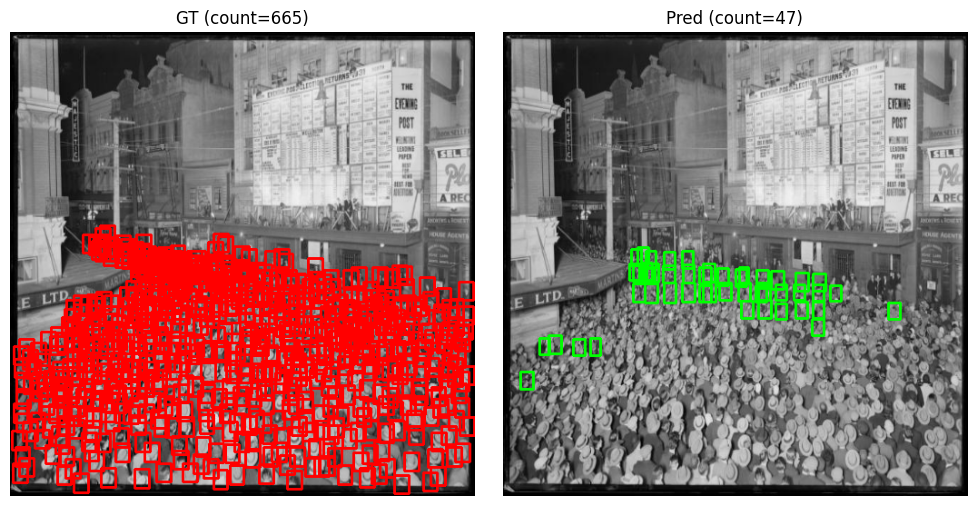

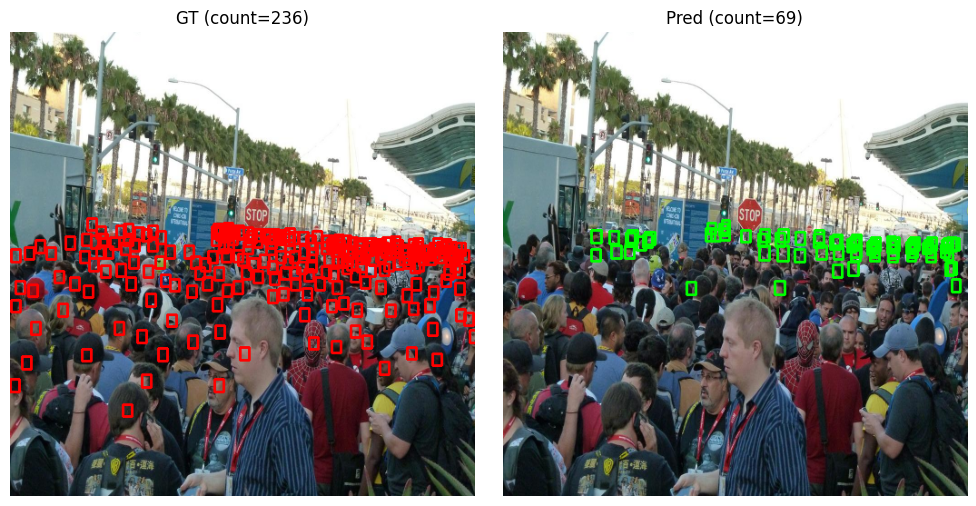

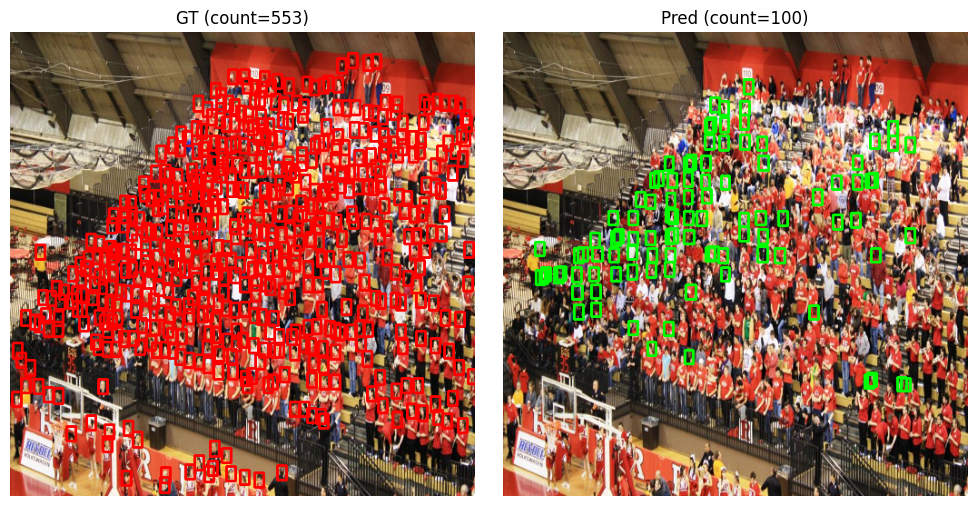

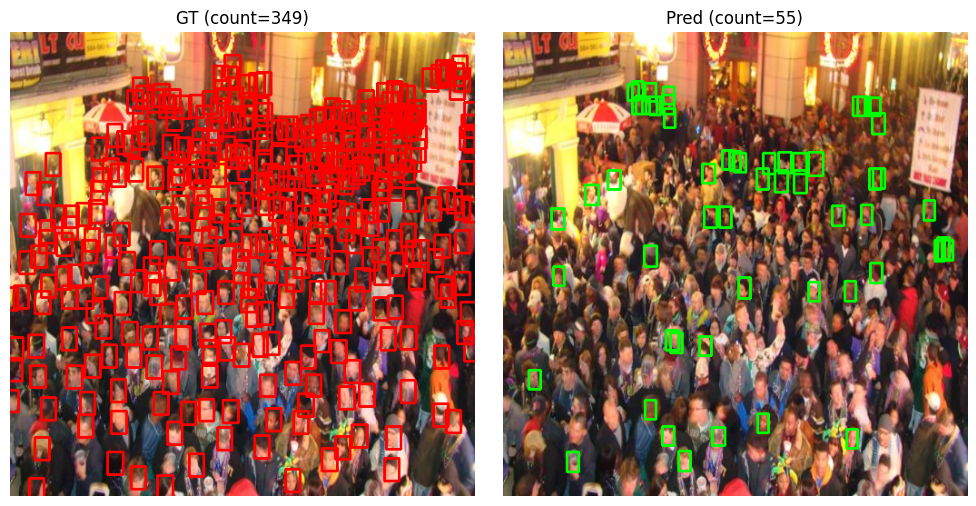

In [17]:
# Load the best saved model weights for Part A from Google Drive
model_A.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/headbox_partA_best.pth",   # <--- Path to best Part A checkpoint
        map_location=device,                               # <--- Load weights onto current device
    )
)

# Move model to the selected device (GPU / CPU)
model_A.to(device)                                        # <--- Ensure model is on correct device

# Visualize predictions on Part A test dataset
visualize_predictions(
    model_A,
    test_dataset_A,
    device,
    max_images=5,        # <--- Number of test images to visualize
    score_thresh=0.5,    # <--- Confidence threshold for displaying predictions
)

### Step 18 – `Visualize Part B predictions`

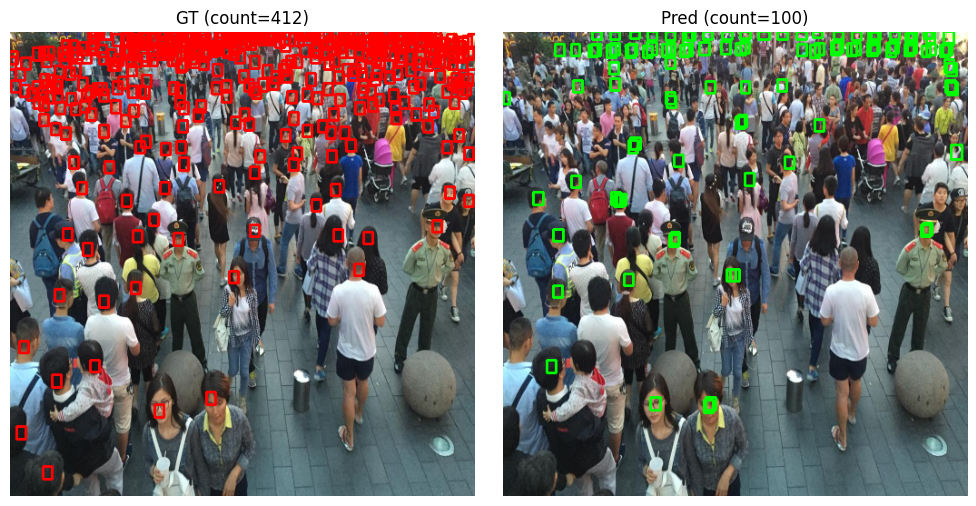

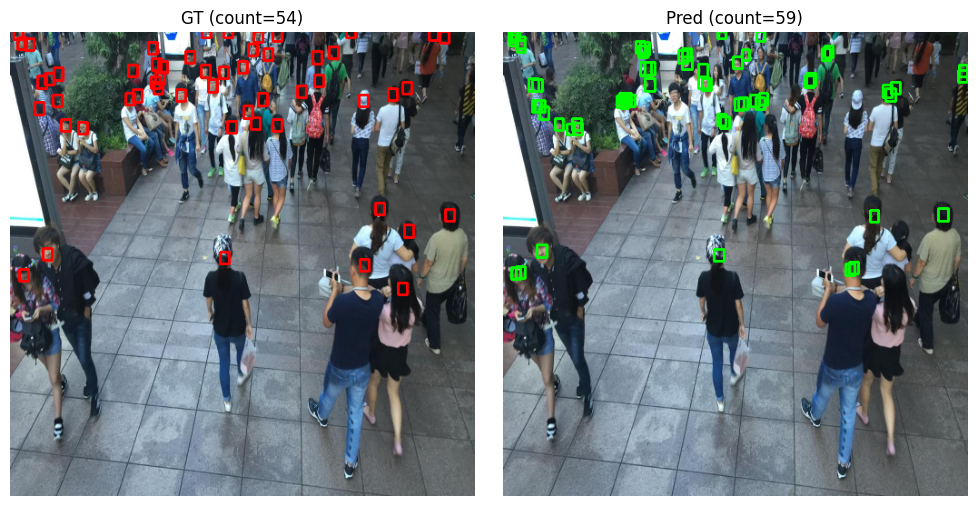

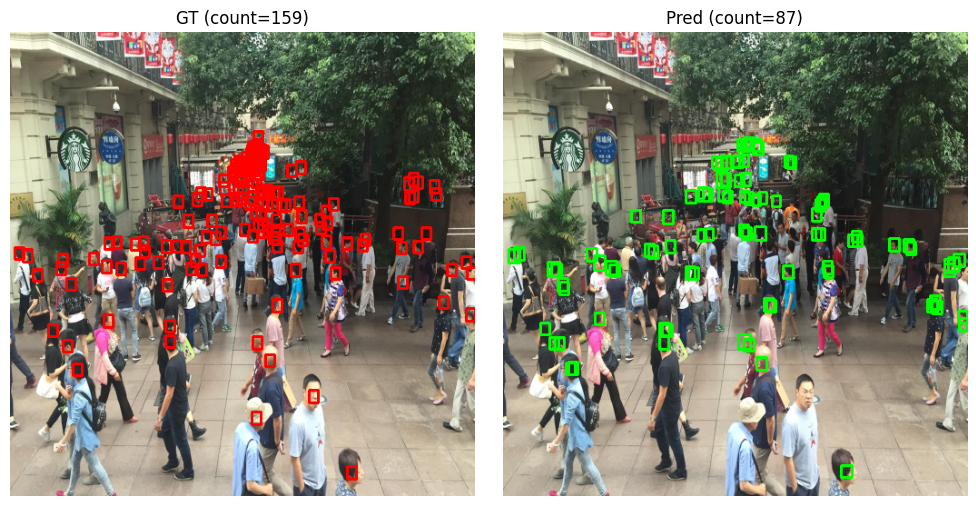

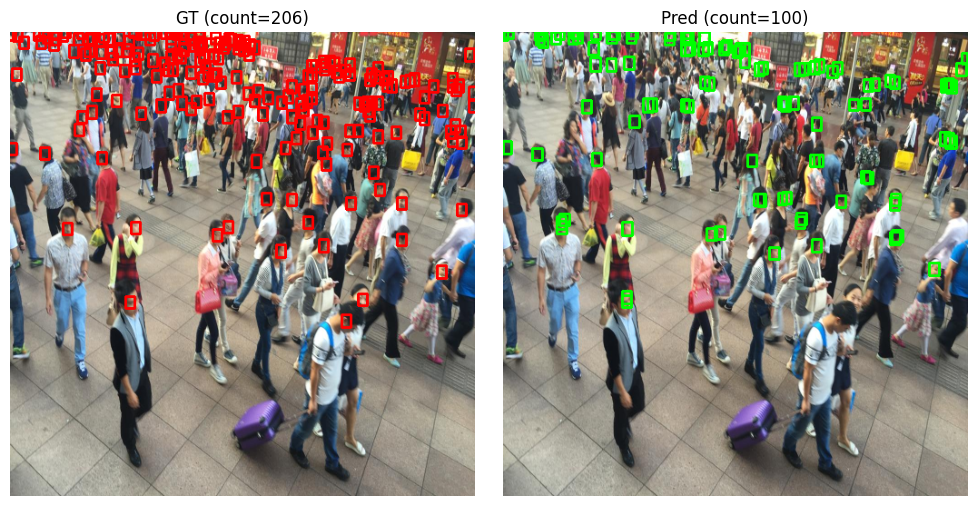

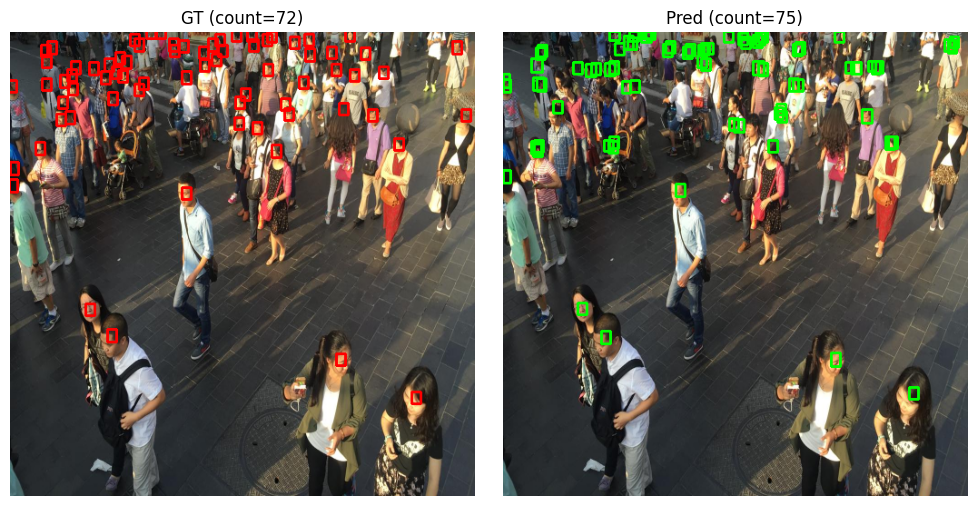

In [18]:
# Load the best saved model weights for Part B from Google Drive
model_B.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/headbox_partB_best.pth",   # <--- Path to best Part B checkpoint
        map_location=device,                               # <--- Load weights onto current device
    )
)

# Move model to the selected device (GPU / CPU)
model_B.to(device)                                        # <--- Ensure model is on correct device

# Visualize predictions on Part B test dataset
visualize_predictions(
    model_B,
    test_dataset_B,
    device,
    max_images=5,        # <--- Number of test images to visualize
    score_thresh=0.5,    # <--- Confidence threshold for displaying predictions
)

### Step 19 – `Final MAE/RMSE on test sets`

In [19]:
# Evaluate final counting performance on Part A test set
mae_A, rmse_A = evaluate_count_mae(
    model_A,
    test_loader_A,
    device,
    score_thresh=0.5,      # <--- Confidence threshold for counting detections
)

# Evaluate final counting performance on Part B test set
mae_B, rmse_B = evaluate_count_mae(
    model_B,
    test_loader_B,
    device,
    score_thresh=0.5,      # <--- Confidence threshold for counting detections
)

# Print final evaluation metrics for Part A
print(
    f"Part A  -> "
    f"MAE: {mae_A:.2f}, "   # <--- Mean Absolute Error
    f"RMSE: {rmse_A:.2f}"  # <--- Root Mean Squared Error
)

# Print final evaluation metrics for Part B
print(
    f"Part B  -> "
    f"MAE: {mae_B:.2f}, "   # <--- Mean Absolute Error
    f"RMSE: {rmse_B:.2f}"  # <--- Root Mean Squared Error
)

Part A  -> MAE: 358.33, RMSE: 514.94
Part B  -> MAE: 54.33, RMSE: 91.39


### Step 20 – `Single image inference`

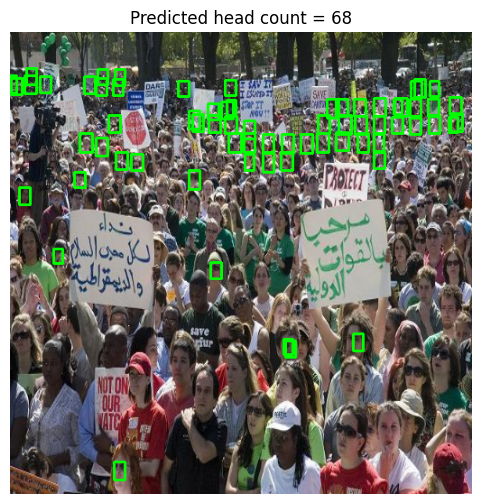

68

In [20]:
@torch.no_grad()   # <--- Disable gradient computation for inference
def detect_on_single_image(
    model,
    img_path,
    device,
    score_thresh=0.5,     # <--- Confidence threshold for keeping detections
):
    # Load image from disk (BGR format by default)
    img = cv2.imread(img_path)

    # Convert image from BGR to RGB (required for visualization / consistency)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to fixed input size used during training
    img_resized = cv2.resize(img, (512, 512))   # <--- Must match training resolution

    # Convert image to tensor and add batch dimension
    img_tensor = (
        transforms.ToTensor()(img_resized)      # <--- Convert to [0,1] tensor
        .to(device)                             # <--- Move tensor to GPU / CPU
        .unsqueeze(0)                           # <--- Add batch dimension (1, C, H, W)
    )

    # Set model to evaluation mode
    model.eval()

    # Run inference on single image
    out = model(img_tensor)[0]                  # <--- Output dict for single image

    # Extract predicted bounding boxes and confidence scores
    boxes = out["boxes"].detach().cpu().numpy()
    scores = out["scores"].detach().cpu().numpy()

    # Keep only predictions above confidence threshold
    keep = scores > score_thresh
    boxes = boxes[keep]

    # Draw predicted bounding boxes on the image
    img_pred = img_resized.copy()
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(
            img_pred,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            (0, 255, 0),        # <--- Green color for predicted boxes
            2,
        )

    # Visualize prediction result
    plt.figure(figsize=(6, 6))                  # <--- Set figure size
    plt.imshow(img_pred)
    plt.title(f"Predicted head count = {len(boxes)}")  # <--- Show predicted count
    plt.axis("off")
    plt.show()

    # Return predicted head count
    return len(boxes)

# Example usage part_A
sample_img = "/content/drive/MyDrive/ShanghaiTech/part_A/test_data/images/IMG_3.jpg"  # <--- Sample test image path
detect_on_single_image(model_A, sample_img,device,)  # <--- Delect on single image

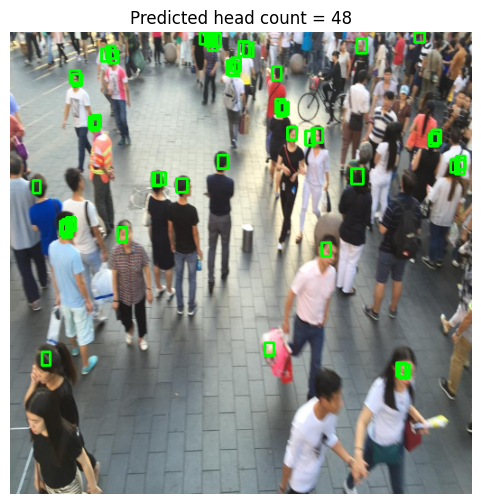

48

In [21]:
# Example usage Part_B
sample_img = "/content/drive/MyDrive/ShanghaiTech/part_B/test_data/images/IMG_3.jpg"  # <--- Sample test image path
detect_on_single_image(model_A, sample_img,device,)  # <--- Delect on single image

## `Project Conclusion and Final Remarks`

This project presented a **deep learning–based head detection and crowd counting system** using the **ShanghaiTech Crowd Counting Dataset**, which consists of **Part A (dense crowds)** and **Part B (sparse crowds)**. The objective was to design and implement a complete pipeline using **PyTorch** in **Google Colab**, covering dataset handling, model design, training, and inference.


###  `Summary of Work Completed`

The following major components were successfully implemented:

-  Dataset loading and preprocessing for the ShanghaiTech dataset  
-  Parsing of ground-truth head annotations from `.mat` files  
-  Conversion of head center points into fixed-size bounding boxes  
-  Custom PyTorch `Dataset` and `DataLoader` with a detection-specific `collate_fn`  
-  A **VGG16-based single-scale CNN detector** for head detection  
-  Grid-based target assignment for bounding box regression and objectness prediction  
-  Proper loss functions for detection (objectness + bounding box regression)  
-  Stable training loop with GPU acceleration  
-  Inference pipeline for head detection and crowd counting  
-  Visualization of predicted head locations against ground truth  

### `Key Observations`

- The model was able to learn meaningful representations for head detection, as indicated by a consistent decrease in training loss.
- Dense crowd scenes (Part A) pose significant challenges due to occlusion and scale variation.
- A detection-based approach provides **interpretable results**, allowing direct visualization and counting of individual heads.
- Proper normalization and target assignment are critical for stable training in detection tasks.
